# LCA of the CeRAS aircraft - Payload Range Diagram

This notebook provides the procedure to obtain a payload-range diagram for the CeRAS aircraft, as presented in the case study from the article "A Comprehensive and Generic Life Cycle Assessment Tool for Overall Aircraft Design".

This notebook requires the [CS-25 package of FAST-OAD](https://github.com/fast-aircraft-design/FAST-OAD_CS25), which can be installed using `pip install --upgrade fast-oad-cs25`.

## Imports

In [11]:
import os.path as pth
import sys
import logging
import fastoad.api as oad
import lca_algebraic as agb
from fastoad.gui.analysis_and_plots import *
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.interpolate import griddata
import brightway2 as bw
import plotly
sys.path.append(pth.abspath("."))

## Working directories and reference files

In [12]:
DATA_FOLDER_PATH = "data"
WORK_FOLDER_PATH = "workdir"
PR_CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH, "payload_range.yml")
PR_SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "payload_range_inputs.xml")

## Payload-range diagram

Note: for the purpose of this study, the original `payload_range.py` from fast-oad-core file was modified to include `needed_block_fuel`, `diversion:fuel`, `holding:fuel` and `reserve:fuel` in the output grid. You can find the modified file in the data folder.

You can modify the properties of the payload-range simulations (e.g., number of points) in the corresponding configuration file [payload_range.yml](./data/payload_range.yml).

In [ ]:
# Generate the inputs
pr_input_file = oad.generate_inputs(PR_CONFIGURATION_FILE, PR_SOURCE_FILE, overwrite=True)
oad.variable_viewer(pr_input_file)

In [ ]:
# Evaluate payload-range data
eval_problem = oad.evaluate_problem(PR_CONFIGURATION_FILE, overwrite=True)

In [ ]:
PR_OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "payload_range_outputs.xml")
oad.variable_viewer(PR_OUTPUT_FILE)

In [ ]:
# Plot figure
fig = oad.payload_range_plot(
    PR_OUTPUT_FILE,
    name="Payload-Range Diagram",
    mission_name="SPP_study",
    variable_of_interest="specific_burned_fuel"
)
fig.show()

## Applying LCA to display environmental impacts on payload range diagram

This part requires a valid ecoinvent license to run the LCA, as detailed in the install instructions of this plugin.

Once the payload-range diagram is calculated, one can apply further LCA calculation on the results.

In [13]:
# Initialise LCA module to build LCA model.
OAD_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'operational_missions_lca_in.xml')
LCA_CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH, "operational_missions_lca_payload_range.yml")
lca_input_file = oad.generate_inputs(LCA_CONFIGURATION_FILE, OAD_OUTPUT_FILE, overwrite=True)

/opt/miniconda3/envs/fastoad-lca/lib/python3.10/site-packages/openmdao/utils/options_dictionary.py:595: OMDeprecationWarning:Option "add_solver" is deprecated for mission module. Please use "use_inner_solvers" instead.


In [14]:
# Retrieve LCA model
my_lca_model = agb.findActivity('model', db_name='Foreground DB')

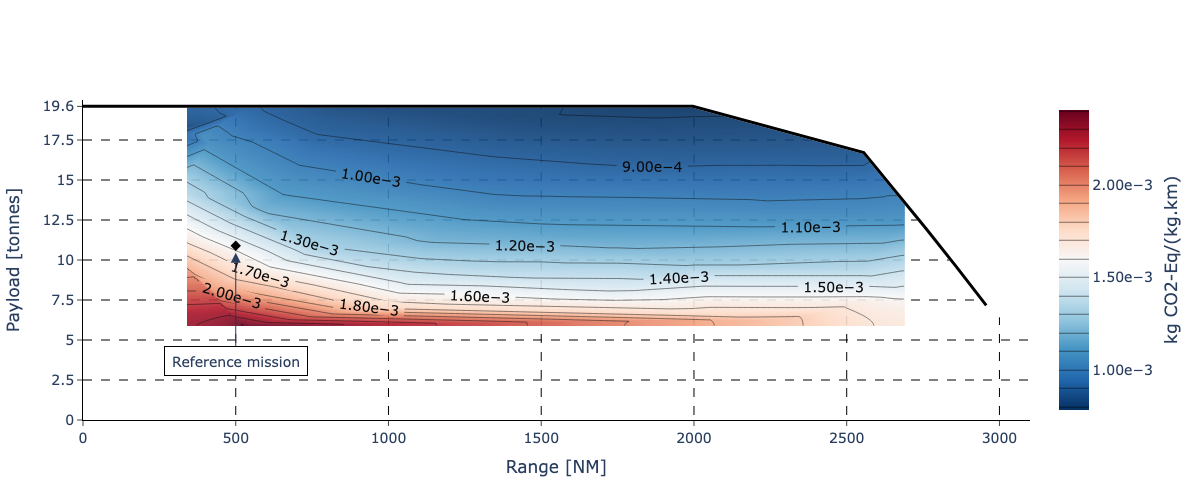

In [15]:
def payload_range_plot_lca(
    aircraft_file_path: Union[str, PathLike],
    name="Payload-Range",
    mission_name="operational",
    variable_of_interest: str = None,
    variable_of_interest_legend: str = None,
    lca_model = agb.findActivity('model', db_name='Foreground DB'),
    lca_params: dict = None,
    x_min: float = 0.0,
    y_min: float = 0.0,
    x_max: float = None,
    y_max: float = None,
    n_contours: int = 12
):
    """
    Returns a figure of the payload-range diagram.

    :param aircraft_file_path: path of data file
    :param name: name to give to the trace added to the figure
    :param mission_name: name of the mission present in the data file to be plotted.
    :param variable_of_interest: impact category to plot (LCA)
    :param variable_of_interest_legend: name to give to variable of interest in plot legend.
    :param lca_params: dict of LCA parameters values corresponding to the mission and data file
    :return: payload-range plot figure
    """
    variables = VariableIO(aircraft_file_path).read()

    ### Contour of the payload range
    range_ = np.asarray(variables[f"data:payload_range:{mission_name}:range"].value)
    range_ = convert_units(range_, "m", "NM")
    payload = np.asarray(variables[f"data:payload_range:{mission_name}:payload"].value)
    payload = convert_units(payload, "kg", "t")
    pr_contour = go.Scatter(
        x=range_[range_<3000],
        y=payload,
        mode="lines",
        line=dict(color="black", width=3),
        showlegend=False,
        name=name,
    )
    
    ### Create mask for a nice payload range
    range_mask = np.append(range_, (1.1 * max(range_), 1.1 * max(range_), 0))
    payload_mask = np.append(payload, (0, 1.1 * max(payload), 1.1 * max(payload)))
    pr_contour_mask = go.Scatter(
        x=range_mask,
        y=payload_mask,
        mode="lines",
        line=dict(color="white", width=3),
        showlegend=False,
        name=name,
        fill="toself",
        fillcolor="white",
    )
    
    ### Grid for the payload range
    range_grid = np.asarray(variables[f"data:payload_range:{mission_name}:grid:range"].value)
    payload_grid = np.asarray(
        variables[f"data:payload_range:{mission_name}:grid:payload"].value
    )

    # LCA calculation
    if isinstance(variable_of_interest, tuple):
        variable_of_interest_unit = bw.Method(variable_of_interest).metadata['unit']
        variable_of_interest_grid = agb.compute_impacts(
            lca_model,
            variable_of_interest,
            **lca_params
        ).values.ravel()

    else: # probably not an lca category but a variable from fast-oad
        variable_of_interest_unit = variables[
            f"data:payload_range:{mission_name}:grid:{variable_of_interest}"
        ].units
        variable_of_interest_grid = np.asarray(
            variables[f"data:payload_range:{mission_name}:grid:{variable_of_interest}"].value
        )
    
    x = convert_units(range_grid, "m", "NM")
    y = convert_units(payload_grid, "kg", "t")
    z = variable_of_interest_grid

    # Convert to meshgrid and apply filtering
    #xi = np.linspace(x.min(), x.max(), 200)
    xi = np.linspace(340, x.max(), 300)
    yi = np.linspace(y.min(), y.max(), 300)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear', rescale=True)
    
    #zi_smooth = gaussian_filter(zi, sigma=.5)  # Adjust sigma for smoothing
    #fig, ax = plt.subplots(figsize=(12, 6))
    #ax.contour(Xi, Yi, zi_smooth, levels=14, linewidths=0.5, colors='k')
    #cntr = ax.contourf(Xi, Yi, zi, levels=14, cmap="RdBu_r")
    #return fig

    # Add to plot
    pr_grid = go.Contour(
                x=xi,
                y=yi,
                z=zi,
                contours=dict(start=min(zi.flatten()), end=max(zi.flatten()), size=(max(z) - min(z)) / n_contours, showlabels = True),
                #contours=dict(start=1.4e-3, end=4.8e-3, size=(max(z) - min(z)) / n_contours, showlabels = True),
                colorbar=dict(
                    title=variable_of_interest_unit + '/(kg.km)',  #'/(pax.km)',
                    titleside="right",
                    #titlefont=dict(size=15, family="Arial, sans-serif"),
                    tickformat=".2e",
                ),
                colorscale="RdBu_r",
                contours_coloring="heatmap",
                opacity=0.95,
                line_smoothing=0.8,
                ncontours=n_contours,
                connectgaps=True
            )

    ### Create hatch overlay where non-CO2 effects are predominant
    #z2 = variable_of_interest_grid * 0.4  # Assuming you have a second grid
    #zi2 = griddata((x, y), z2, (xi[None, :], yi[:, None]), method='linear', rescale=True)
    #mask = zi > 2 * zi2
    #hatch_overlay = go.Contour(
    #    x=xi,
    #    y=yi,
    #    z=mask.astype(int),  # Convert mask to binary for contour plotting
    #    showscale=False,  # No colorbar for hatch
    #    colorscale=[[0, "rgba(0,0,0,0)"], [1, "rgba(0,0,0,0.5)"]],  # Transparent and shaded region
    #    contours=dict(start=0.5, end=0.5, size=1),
    #    opacity=0.5,  # Adjust hatch visibility
    #    line=dict(width=0),
    #    connectgaps=True
    #)

    ### Plot
    fig = go.Figure()
    fig.add_trace(pr_contour_mask)
    fig.add_trace(pr_contour)
    fig.add_trace(pr_grid)
    #fig.add_trace(hatch_overlay)
    #fig.add_trace(go.Scatter(x=x, y=y, hovertext=z, mode="markers"))  

    # Add point for reference mission
    fig.add_trace(go.Scatter(x=[500.0], y=[10.8864], mode="markers", marker_symbol='diamond', marker_color="black", marker_size=8,))
    fig.add_annotation(
        x=500.0,
        y=10.8864,
        ax=0,
        ay=115,
        text="Reference mission",
        showarrow=True,
        arrowhead=2,
        arrowsize=2,
        standoff=7,
        xanchor="center",
        bordercolor="black",
        borderwidth=1,
        borderpad=4,
        bgcolor="white",
    )

    # Update layout
    if not x_max:
        x_max = max(payload_mask)
    if not y_max:
        y_max = max(range_mask)
    
    fig.update_layout(
        xaxis_title="Range [NM]",
        yaxis_title="Payload [tonnes]",
        yaxis_range=[y_min, y_max],
        xaxis_range=[x_min, x_max],
        showlegend=False,
        height=500,
        width=900,
        #title={"text": name, "y": 0.9, "x": 0.5, "xanchor": "center", "yanchor": "top"},
        plot_bgcolor="white",
        font=dict(
            #family="Courier New, monospace",
            size=14,
        )
    )
    fig.update_xaxes(
        ticks="outside", 
        gridcolor='black', griddash='dash',
        showline=True, linecolor='black'
        )
    fig.update_yaxes(
        ticks="outside", tickvals=[val for val in np.arange(0, 20, 2.5)] + [round(max(payload),1)], 
        gridcolor='black', griddash='dash', 
        showline=True, linecolor='black'
    )

    return fig


# Payload range outputs
WORK_FOLDER_PATH = "workdir"
payload_range_outputs = pth.join(WORK_FOLDER_PATH,'payload_range_outputs.xml')
variables = VariableIO(payload_range_outputs).read()

# Assign values for LCA
#payload_150_PAX = 13608.0  #variables['data:weight:aircraft:max_payload'].value[0]
#load_factor = [payload / payload_150_PAX for payload in variables['data:payload_range:SPP_study:grid:payload'].value]
payload_mass = variables['data:payload_range:SPP_study:grid:payload'].value
main_route_distance = [dist / 1000 for dist in variables['data:payload_range:SPP_study:grid:range'].value]  # convert from meters to km
needed_block_fuel = variables['data:payload_range:SPP_study:grid:block_fuel'].value  # total fuel for main route + diversion + holding + reserve
diversion_fuel = variables['data:payload_range:SPP_study:grid:diversion_fuel'].value
holding_fuel = variables['data:payload_range:SPP_study:grid:holding_fuel'].value
reserve_fuel = variables['data:payload_range:SPP_study:grid:reserve_fuel'].value

lca_params = {
    'data__mission__SPP_study__main_route__distance': main_route_distance,
    'data__mission__SPP_study__needed_block_fuel': needed_block_fuel,
    'data__mission__SPP_study__diversion__fuel': diversion_fuel,
    'data__mission__SPP_study__holding__fuel': holding_fuel,
    'data__mission__SPP_study__reserve__fuel': reserve_fuel,
    'year': 2025,
    'model': 'remind',
    'pathway': 'SSP2_PkBudg1150',
    #'lca__parameters__load_factor': 90.72 / 0.8,  # load_factor,
    #'data__TLAR__NPAX': 1.0,  # 150,
    'data__mission__SPP_study__payload': payload_mass,
    'lca__parameters__lifetime_cycle_number': 35000.0,
    'lca__parameters__fuel_contrail_coefficient': 0.63,
    'lca__parameters__fossil_kerosene_share': 1.0,
    'lca__parameters__emission_index_co2_fuel': 3.16,
    'lca__parameters__emission_index_nox_kerosene': 0.01514,
    'lca__parameters__emission_index_sulfur_kerosene': 0.0012,
    'lca__parameters__emission_index_soot_kerosene': 3e-05,
    'lca__parameters__residues_biofuel_share': 0.0,
    'lca__parameters__emission_index_nox_alternative_fuel': 0.01514,
    'lca__parameters__emission_index_sulfur_alternative_fuel': 0.0,
    'lca__parameters__emission_index_soot_alternative_fuel': 6e-06,
    'lca__parameters__products_biofuel_share': 0.0,
    'lca__parameters__efuel_share': 0.0,
    'lca__parameters__elec_solar_share': 0.0,
    'data__weight__aircraft__OWE': 41990.170585323955
}

# Plot payload range diagram with LCA values
fig = payload_range_plot_lca(
    payload_range_outputs, 
    name="Payload-Range Diagram",
    mission_name="SPP_study",
    #variable_of_interest="specific_burned_fuel",
    variable_of_interest=('ReCiPe 2016 v1.03, midpoint (H)', 'climate change',  'global warming potential (GWP100)'),
    lca_model=my_lca_model,
    lca_params=lca_params,
    x_min = 0.0,
    y_min = 0.0,
    x_max = 3100.0,
    y_max = 20.0,
    n_contours = 21
)
fig.show()
#plotly.io.write_image(fig, 'payload_range_CO2.pdf', format='pdf')